## MLM-tuned Contour plot
* Inputs:
  * raw data: `../data/raw_cx_data.json` (10.01)
  * CV splits: `../data/cv_splits_10.json` (10.01)
  * MLM-tuned: `../data/models/apricot_mlm_03` (20.10)  
* Outputs:
  * (none)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import pickle
from pathlib import Path
from hashlib import sha256
from tqdm.auto import tqdm
import torch
import numpy as np
from itertools import chain
from torch.nn import CrossEntropyLoss
from transformers import BertTokenizerFast, BertForMaskedLM, BertModel
from import_conart import conart
from conart.mlm_masks import batched_text, batched_text_gan, get_equality_constraints
from conart.sample import sample_site

In [3]:
device = torch.device("cuda") \
         if torch.cuda.is_available() else torch.device("cpu")

In [4]:
data_path = "../data/raw_cx_data.json"
with open(data_path, "r", encoding="UTF-8") as fin:
    data = json.load(fin)
## Check data is the same
h = sha256()
h.update(pickle.dumps(data))
data_hash = h.digest().hex()[:6]
assert data_hash == "4063b4"
len(data) # should be 11642

11642

In [5]:
## Read cv splits
with open("../data/cv_splits_10.json", "r") as fin:
    cv_splits = json.load(fin)

In [6]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-chinese')
# model = BertForMaskedLM.from_pretrained('bert-base-chinese')
# model = BertForMaskedLM.from_pretrained('ckiplab/bert-base-chinese')
model = BertForMaskedLM.from_pretrained('../data/models/apricot_mlm_03')
model = model.to(device)
ckip_model = BertForMaskedLM.from_pretrained('ckiplab/bert-base-chinese')
ckip_model = ckip_model.to(device)

## Checking input data

In [7]:
train_idxs, test_idxs = cv_splits[0].values()

In [8]:
xx = data[1211]
xx

{'board': 'BabyMother',
 'text': ['再', '擠', '也', '擠', '不', '出來', '了'],
 'cnstr': ['O', 'BX', 'IX', 'IX', 'IX', 'IX', 'O'],
 'slot': ['O', 'BV', 'BC', 'BV', 'BC', 'BV', 'O'],
 'cnstr_form': ['v', '也', 'v', '不', 'X'],
 'cnstr_example': ['擠', '也', '擠', '不', '出來']}

In [9]:
batch = batched_text(data, train_idxs[:5], "vslot")
def get_cnstr_eqs(cxinst):
    cnstr_eqs = {
        "text": "".join(chain.from_iterable(cxinst["text"])),
        "form": cxinst["cnstr_form"],
        "example": cxinst["cnstr_example"],
        "eqs": get_equality_constraints(cxinst)
    }
    return cnstr_eqs
list(batch.keys())

['masked', 'text', 'mindex', 'mindex_bool']

## Calculate Unigram baseline

In [10]:
import re
v_instances = []
for idx in train_idxs:
    try:
        eqs = get_cnstr_eqs(data[idx])    
    except ValueError:
        continue
        
    for v, inst in zip(eqs["form"], eqs["example"]):
        if re.match("[a-z0-9]+", v):            
            v_instances.append(inst)

In [11]:
len(v_instances)

19778

In [12]:
from collections import Counter
uni_freq = Counter(chain.from_iterable(v_instances))
def query_uni_freq(char):
    return uni_freq.get(char, 0)

In [13]:
uni_base_chars = [x[0] for x in uni_freq.most_common(10)]
uni_base_ids = tokenizer.convert_tokens_to_ids(uni_base_chars)
uni_base_ids

[3647, 2682, 4692, 1391, 5050, 5481, 5464, 6341, 3121, 3119]

## Find a sampel case

In [14]:
## case: 100
CASE_INDEX = test_idxs[100]

In [15]:
bb = batched_text(data, [CASE_INDEX], 'vslot')

In [16]:
"".join(bb["text"][0])

'裡面的紅蘿蔔和馬鈴薯也很入味泡麵這樣拌一拌味道很棒耶'

In [17]:
tgt_char = bb["text"][0][bb["mindex"][0][0]]
tgt_idx = tokenizer.convert_tokens_to_ids(tgt_char)
print("char, idx: ", tgt_char, tgt_idx)

char, idx:  拌 2863


In [18]:
def get_predicted_ids(samples):
    ids = samples["ids"]    
    logits = samples["logits"]
    all_ids = set(ids[0, :].tolist())
    for i in range(1,ids.shape[0]):
        all_ids = all_ids.union(ids[i,:].tolist())
    all_ids = list(all_ids)        
    return all_ids

In [19]:
# conart predictions
conart_samples = sample_site(bb, model, tokenizer, n_sample=10)[0]
conart_samples

{'ids': array([[2863, 4215, 1391, 4143, 4156, 3888, 1933, 3796, 5892, 4171],
        [2863, 1391, 4215, 4156, 3888, 4143, 3796, 1933, 4171,  976]]),
 'probs': array([[-0.17468047, -3.256768  , -3.443982  , -4.0479975 , -4.124008  ,
         -4.2577524 , -5.5418177 , -5.6021223 , -5.676072  , -5.925703  ],
        [-0.4559257 , -2.240133  , -2.4941814 , -3.7266328 , -3.7990692 ,
         -3.8766124 , -4.391988  , -4.4194965 , -4.9139423 , -5.0177546 ]],
       dtype=float32),
 'logits': array([[17.644827 , 14.562739 , 14.375525 , 13.77151  , 13.695499 ,
         13.561755 , 12.27769  , 12.217385 , 12.1434355, 11.893805 ],
        [16.227083 , 14.442876 , 14.1888275, 12.956376 , 12.88394  ,
         12.8063965, 12.291021 , 12.263513 , 11.769067 , 11.665255 ]],
       dtype=float32)}

In [20]:
tokenizer.batch_decode(conart_samples["ids"])

['拌 煮 吃 炒 炸 涮 夾 泡 蒸 烤', '拌 吃 煮 炸 涮 炒 泡 夾 烤 做']

In [21]:
conart_samples_merged = sample_site(bb, model, tokenizer, merge_pair2=True, n_sample=10)[0]
tokenizer.batch_decode(conart_samples_merged["ids"])

['拌', '吃', '煮', '炸', '炒', '涮', '夾', '泡', '烤', '蒸']

In [22]:
conart_samples = sample_site(bb, model, tokenizer, n_sample=10)[0]
conart_ids = get_predicted_ids(conart_samples)
print("conart: ", conart_ids)
ckip_samples = sample_site(bb, ckip_model, tokenizer, n_sample=10)[0]
ckip_ids = get_predicted_ids(ckip_samples)
print("ckip:   ", ckip_ids)

conart:  [5892, 4171, 1933, 1391, 4143, 2863, 3888, 976, 3796, 4215, 4156]
ckip:    [7953, 4638, 679, 2863, 943, 4275, 1846, 4156, 4676, 4934, 4171, 4813, 976, 1366, 868, 6887, 3564, 1391, 4215, 889]


In [23]:
union_ids = np.array(list(set(chain(uni_base_ids, conart_ids, ckip_ids))))
tgt_loc = np.nonzero(union_ids == tgt_idx)[0][0]
print("len(union_ids): ", len(union_ids))
print("target location in union_ids: ", tgt_loc)

len(union_ids):  34
target location in union_ids:  8


In [24]:
def to_outer_lprob(logits):
    pmat = np.add.outer(logits[0, :], logits[1, :])
    probs = np.exp(pmat)/np.exp(pmat).sum()
    return np.log(probs+1e-5)

conart_logits = sample_site(bb, model, tokenizer, query_idxs=np.tile(union_ids, (2, 1)))[0]["logits"]
conart_lprobs = to_outer_lprob(conart_logits)
ckip_logits = sample_site(bb, ckip_model, tokenizer, query_idxs=np.tile(union_ids, (2, 1)))[0]["logits"]
ckip_lprobs = to_outer_lprob(ckip_logits)


In [25]:
uni_freqs = np.array([query_uni_freq(x) for x 
             in tokenizer.convert_ids_to_tokens(union_ids)])
uni_probs = uni_freqs/uni_freqs.sum()
uni_lprobs = np.log(uni_probs+1e-5)
uni_lprobs = np.add.outer(uni_lprobs, uni_lprobs)

In [26]:
lprobs_stack = np.dstack([conart_lprobs, ckip_lprobs, uni_lprobs])
ids_order = np.einsum('ijk->i', lprobs_stack).argsort()[::-1]
ids_order = np.roll(ids_order, len(ids_order)//2)
img_vmin = lprobs_stack.min()
img_vmax = lprobs_stack.max()

In [27]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches
def plot_probs(lprobs, ids_order, tgt_loc, ax, title):            
    tgt_loc = np.where(ids_order == tgt_loc)[0][0]
    mat = lprobs[ids_order, :][:, ids_order]
    ax.imshow(mat, cmap="viridis")
    ax.set_title(title, fontsize=18, y=-0.15)
    ymin, ymax = ax.get_ylim()
    rect_x = patches.Rectangle((tgt_loc-0.5, -0.2), 1, lprobs.shape[1]-0.6, linewidth=1, edgecolor='white', facecolor='none')
    rect_y = patches.Rectangle((-0.2, tgt_loc-0.5), lprobs.shape[0]-0.6, 1, linewidth=1, edgecolor='white', facecolor='none')
    ax.add_patch(rect_x)
    ax.add_patch(rect_y)    

Text(0.5, 0.95, 'Prediction Distributions of Different Models')

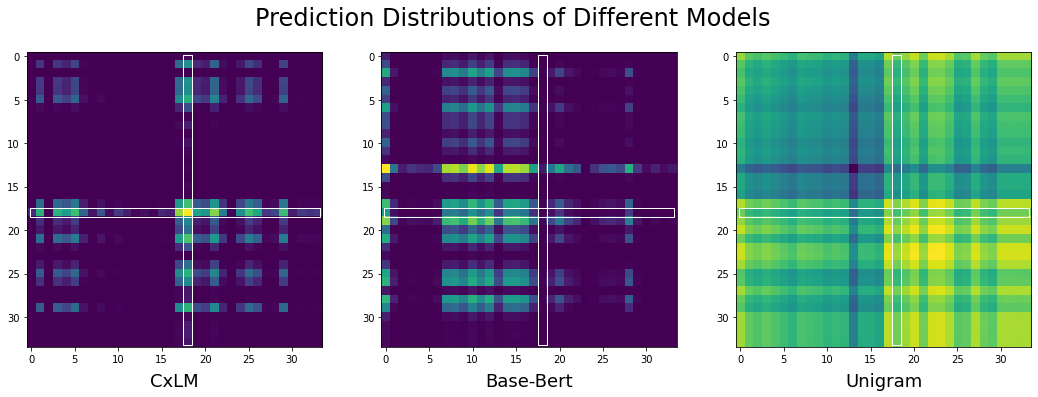

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(18,6))
plot_probs(conart_lprobs, ids_order, tgt_loc, ax=axes[0], title='CxLM')
plot_probs(ckip_lprobs, ids_order, tgt_loc, ax=axes[1], title="Base-Bert")
plot_probs(uni_lprobs, ids_order, tgt_loc, ax=axes[2], title="Unigram")
fig.suptitle("Prediction Distributions of Different Models", y=0.95, fontsize=24)

## Output Plot

In [29]:
fig.savefig("../data/figures/pred_distr.png", dpi=200, bbox_inches='tight')